#### ZeroBond

In [1]:
import sys, os

relative_path = os.path.join("..")
print(f"Relative path: {relative_path}")
sys.path.append(os.path.abspath(relative_path))
valid_paths = [p for p in sys.path if os.path.exists(p)]
print(f"Valid paths: {valid_paths}")
import pytest
import tensorflow as tf
import pandas as pd
import numpy as np
from scripts.utils.utils.utils import (
    ZeroBond,
    FinanceUtils,
    VisualizationHelper
)
from scripts.trainer.trainer import simulate

T = 8

T_dicts = {
    t: 0 for t in range(1, T)
}
results_t = {
    t: None for t in range(1, T)
}
# Steps per year
nsteps_per_year = 48
# Params for check
for t in range(T, T + 1):
    sigmas = [0.01, 0.02, 0.04, 0.08, 0.16]
    df_results_list = []
    for sigma in sigmas:
        nsteps = t * nsteps_per_year
        # Fixed params
        simple_params = {
            "T": t,
            "N_steps": nsteps,
            "dim": 1,
            "sigma": sigma,
            "nsims": 1000
        }
        data, _ = simulate(
            T = simple_params["T"], 
            N_steps = simple_params["N_steps"], 
            dim = simple_params["dim"],
            sigma = simple_params["sigma"], 
            nsims = simple_params["nsims"]
        )

        # Get data to process the ZeroBound
        delta_x = data.delta_x_0.values
        xt = data.X_0.values
        dt = data.dt.values
        t_unique = data.dt.unique()
        dict_C = {dt:FinanceUtils.C(dt, sigma_value = simple_params["sigma"]) for dt in t_unique}
        ct = data.apply(lambda x: dict_C[x['dt']], axis = 1)
        nt = ZeroBond.N_tensor(dt,xt,ct)
        # Convert to tensors
        xt = tf.convert_to_tensor(xt, dtype = tf.float64)
        delta_x = tf.convert_to_tensor(delta_x,dtype = tf.float64)
        dt = tf.convert_to_tensor(dt, dtype = tf.float64)
        ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
        T = tf.Variable(np.float64(T), name = 'T', trainable=False)
        # Fix the batch size
        batch_size = int(xt.shape[0] / nsteps)
        # Real values
        v_real = ZeroBond.Z_tensor(xt, dt, T, ct)
        v_real_reshaped = tf.reshape(v_real,(batch_size,nsteps))
        n_tensor = ZeroBond.N_tensor(dt, xt, ct)
        # Derivative:
        xt = tf.Variable(xt, name = 'xn', trainable = True)
        dt = tf.Variable(dt, name = 'tn', trainable = False)
        ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
        with tf.GradientTape() as tape:
            y = ZeroBond.Z_normalized(xt, dt, T, ct)
        grad_df = tape.gradient(y, {'xn':xt})
        grads = grad_df['xn']
        # Simulate - LGM step:
        grads_reshaped = tf.reshape(grads, (batch_size, nsteps))
        xt_reshaped = tf.reshape(xt, (batch_size, nsteps))
        delta_x_reshaped = tf.reshape(delta_x, (batch_size, nsteps))
        # Calculate the MVP
        v = np.ones((batch_size, nsteps)) * np.float64(v_real_reshaped[0, 0])
        for i in range(1, nsteps):
            v[:, i] = (v[:, i - 1] + grads_reshaped[:, i - 1] * delta_x_reshaped[:, i])
        # Calculate errors absolute
        v_real = np.array(tf.reshape(v_real_reshaped, -1))
        v_column = np.array(tf.reshape(v, -1)) * n_tensor.numpy()
        dt_list = np.array(dt)
        df_tmp = pd.DataFrame(zip(xt.numpy(), v_real, v_column, dt_list, n_tensor.numpy()), columns = ["xt", "v_real","v_est","dt", "n"])
        df_tmp["sigma"] = sigma
        df_results_list.append(
            df_tmp
        )
df_results = pd.concat(df_results_list)

Relative path: ..
Valid paths: ['c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE\\notebooks', 'C:\\Users\\borja\\anaconda3\\DLLs', 'C:\\Users\\borja\\anaconda3\\Lib', 'C:\\Users\\borja\\anaconda3', 'c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE\\.venv', 'c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE\\.venv\\Lib\\site-packages', 'c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE\\.venv\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\borja\\Documents\\GitHub\\LGM_BFSDE']
[MEMORY] Simulation memory usage: 0.0057220458984375 Gb
[MEMORY] Simulation memory usage: 0.0057220458984375 Gb
[MEMORY] Simulation memory usage: 0.0057220458984375 Gb
[MEMORY] Simulation memory usage: 0.0057220458984375 Gb
[MEMORY] Simulation memory usage: 0.0057220458984375 Gb


In [2]:
df_results_mc = df_results.groupby(
    ["dt", "sigma"]
).agg(
    v_real = ("v_real","mean")
).reset_index()

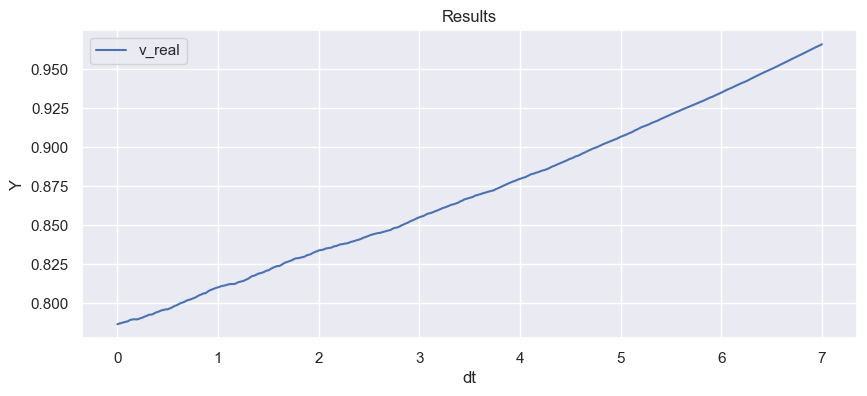

In [5]:
VisualizationHelper.plot_serie(df_results_mc, x = "dt", y = "v_real", xlabel="dt", hue = "sigma")